# Performance of MiDaS model

https://pytorch.org/hub/intelisl_midas_v2/

**MiDaS models for computing relative depth from a single image.**

<img src="https://pytorch.org/assets/images/midas_samples.png" alt="alt" width="50%"/>


### Model Description

[MiDaS](https://arxiv.org/abs/1907.01341) computes relative inverse depth from a single image. The repository provides multiple models that cover different use cases ranging from a small, high-speed model to a very large model that provide the highest accuracy. The models have been trained on 10 distinct datasets using
multi-objective optimization to ensure high quality on a wide range of inputs.

### Dependencies

MiDaS depends on [timm](https://github.com/rwightman/pytorch-image-models).

In [1]:
!pip install timm

In [ ]:
!pip3 install torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
import cv2
import torch

In [3]:
torch.__version__

'1.9.0+cpu'

In [4]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/febrin/.cache/torch/hub/intel-isl_MiDaS_master


In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (dro

Load transforms to resize and normalize the image for large or small model

In [7]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/febrin/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

In [10]:
synth_img = cv2.imread('../images/dataset2/SBXCameraSensor_Top_PolyBag_00000009.png')
synth_img = cv2.cvtColor(synth_img, cv2.COLOR_BGR2RGB)

prod_img = cv2.imread('../images/production/color_production_4.png')
prod_img = cv2.cvtColor(prod_img, cv2.COLOR_BGR2RGB)

lab_img = cv2.imread('../images/experiment_on_robot/item_left_images/item_left_height_1.png')
lab_img = cv2.cvtColor(lab_img, cv2.COLOR_BGR2RGB)

synth_input_batch = transform(synth_img).to(device)
prod_input_batch = transform(prod_img).to(device)
lab_input_batch = transform(lab_img).to(device)

In [12]:
with torch.no_grad():
    synth_prediction = midas(synth_input_batch)
    synth_prediction = torch.nn.functional.interpolate(
        synth_prediction.unsqueeze(1),
        size=synth_img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    prod_prediction = midas(prod_input_batch)
    prod_prediction = torch.nn.functional.interpolate(
        prod_prediction.unsqueeze(1),
        size=prod_img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    
    lab_prediction = midas(lab_input_batch)
    lab_prediction = torch.nn.functional.interpolate(
        lab_prediction.unsqueeze(1),
        size=prod_img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    

synth_output = synth_prediction.cpu().numpy()
prod_output = prod_prediction.cpu().numpy()
lab_output = lab_prediction.cpu().numpy()

# Visualize depth and normals

In [15]:
import numba
import numpy as np
@numba.jit(nopython=True)


def get_normals_from_depth(depth_img_arr: np.ndarray) -> np.ndarray:
    n, m = depth_img_arr.shape
    normals_img_arr = np.zeros((n, m, 3))

    for x in range(1, n - 1):
        for y in range(1, m - 1):
            dzdx = (depth_img_arr[x + 1, y] - depth_img_arr[x - 1, y]) / 2.0
            dzdy = (depth_img_arr[x, y + 1] - depth_img_arr[x, y - 1]) / 2.0

            direction = np.array([-dzdx, -dzdy, 1.0], dtype=np.float32)
            magnitude = np.sqrt((direction ** 2).sum())
            normals_img_arr[x, y] = direction / magnitude
    return normals_img_arr

def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


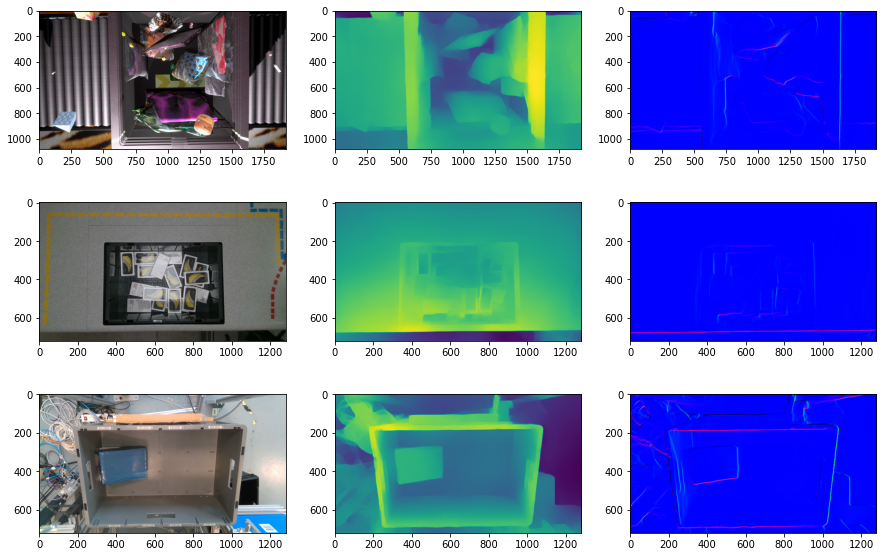

In [18]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(3, 3)
f.set_figheight(10)
f.set_figwidth(15)

axes[0, 0].imshow(synth_img)
axes[0, 1].imshow(synth_output)
axes[0, 2].imshow(get_normals_from_depth(synth_output))

axes[1, 0].imshow(prod_img)
axes[1, 1].imshow(prod_output)
axes[1, 2].imshow(get_normals_from_depth(prod_output))

axes[2, 0].imshow(lab_img)
axes[2, 1].imshow(lab_output)
axes[2, 2].imshow(get_normals_from_depth(lab_output))

# Doggy

In [19]:
import urllib.request

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7f4741fd0940>)

In [20]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

/home/febrin/.local/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


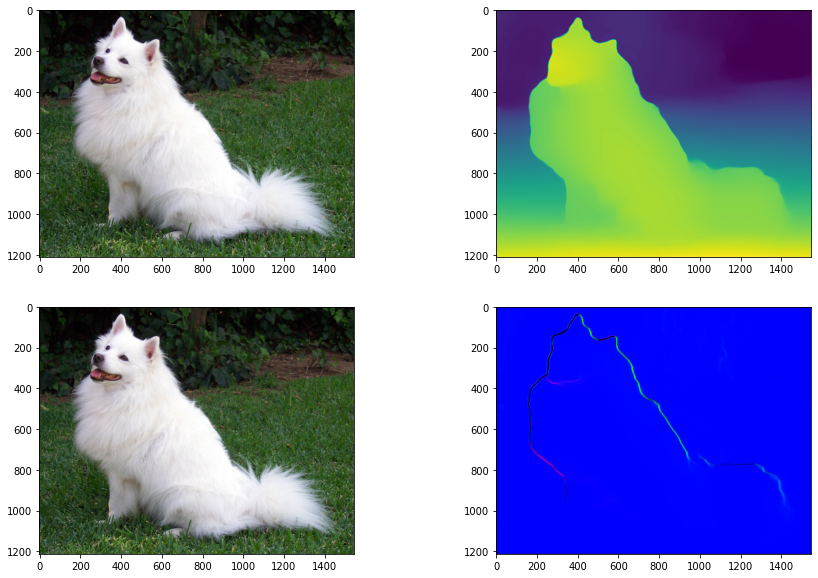

In [21]:
f, axes = plt.subplots(2, 2)
f.set_figheight(10)
f.set_figwidth(15)
axes[0, 0].imshow(img)
axes[0, 1].imshow(output)
axes[1, 0].imshow(img)
axes[1, 1].imshow(get_normals_from_depth(output))